<center>
<img src="https://github.com/Yorko/mlcourse.ai/blob/master/img/ods_stickers.jpg?raw=1">
## Открытый курс по машинному обучению. Сессия № 2
Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Тема 10. Бустинг
## <center>Часть 6. Борьба с недообучением и переобучением Xgboost

**Построим кривые вадидации Xgboost по числу деревьев в задаче классификации синтетических данных.**

In [0]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import validation_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.datasets import make_classification
from xgboost.sklearn import XGBClassifier
from scipy.sparse import vstack

**Генерируем синтетические данные.**

In [14]:
X, y = make_classification(n_samples=1000, n_features=20, n_informative=8, 
                           n_redundant=3, n_repeated=2, random_state=42)
X.shape, y.shape

((1000, 20), (1000,))

**Будем проводить 10-кратную стратифицированную кросс-валидацию. По умолчанию в статьях по машинному обучению и статистике используется именно такая.**

In [0]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

**Посмотрим, как число деревьев влияет на качество модели.**

In [17]:
default_params = {
    'objective': 'binary:logistic',
    'max_depth': 1,
    'learning_rate': 0.3,
    'seed': 42
}

n_estimators_range = np.linspace(1, 200, 10).astype('int')

train_scores, test_scores = validation_curve(
    XGBClassifier(**default_params),
    X, y,
    param_name = 'n_estimators',
    param_range = n_estimators_range,
    cv=cv.split(X, y),
    scoring='accuracy',
    n_jobs=-1
)

train_scores.shape, test_scores.shape

((10, 10), (10, 10))

**Построим кривые валидации.**

In [18]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

train_scores_mean.shape

(10,)

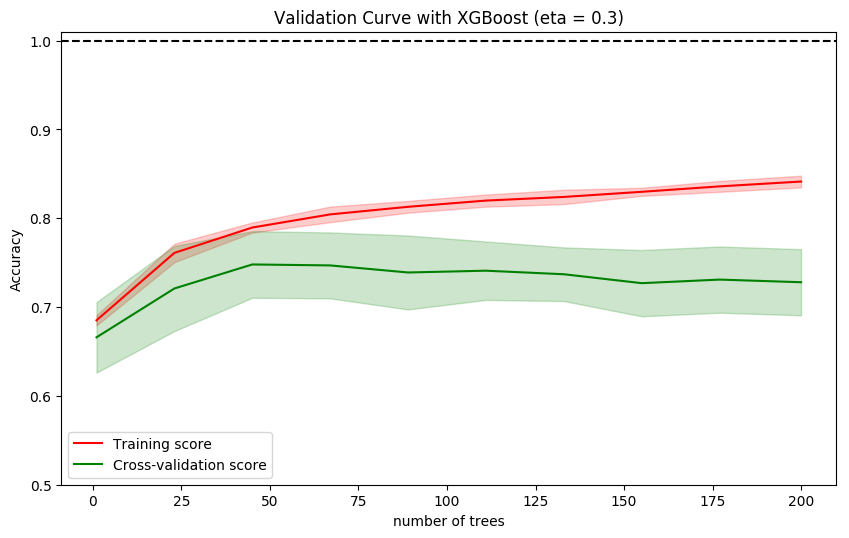

Best cross-validation result (0.75) obtained for 45 trees


In [19]:
fig = plt.figure(figsize=(10, 6), dpi=100)

plt.title("Validation Curve with XGBoost (eta = 0.3)")
plt.xlabel("number of trees")
plt.ylabel("Accuracy")
plt.ylim(0.5, 1.01)

plt.plot(n_estimators_range,
             train_scores_mean,
             label="Training score",
             color="r")

plt.plot(n_estimators_range,
             test_scores_mean, 
             label="Cross-validation score",
             color="g")

plt.fill_between(n_estimators_range, 
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, 
                 alpha=0.2, color="r")

plt.fill_between(n_estimators_range,
                 test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std,
                 alpha=0.2, color="g")

plt.axhline(y=1, color='k', ls='dashed')

plt.legend(loc="best")
plt.show()

i = np.argmax(test_scores_mean)
print("Best cross-validation result ({0:.2f}) obtained for {1} trees".format(test_scores_mean[i], 
                                                                             n_estimators_range[i]))

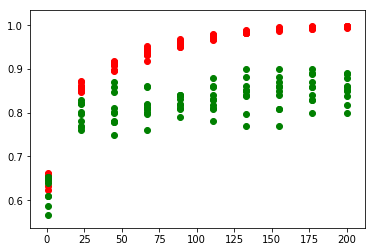

In [29]:
for i in range(train_scores.shape[1]):
  plt.scatter(n_estimators_range, train_scores[:,i], c='r')
for i in range(test_scores.shape[1]):
  plt.scatter(n_estimators_range, test_scores[:,i], c='g')
plt.show()

**Что заметно:**

- Доля правильных ответов на обучении продолжает расти, хотя на валидации - уже нет
- Когда деревьев меньше 25 разброс (variance) ошибки невелик, но и смещение (bias) велико
- Начиная с 25 деревьев, разброс ошибки начинает расти
- Модель доаольно стабильна: дальнейшее увеличение ее сложности не приводит к увеличению разброса ошибки.

Оптимальное в данном случае сочетание разброса и смещение наблюдается примерно при 50 итерациях. Хотя разброс все же велик.

### Что можно улучшить?

#### Снижение разброса
Для уменьшения сложности модели можно:
- использовать меньше признаков (например, отбор)
- использовать больше объектов (например, искусственно созданных)
- увеличить регуляризацию

В случае XGBoost можно:
- уменьшать максимальную глубину деревьев(`max_depth`)
- увеличивать значение параметра `min_child_weight`
- увеличивать значение параметра `gamma`
- добавлять больше "случайности" за счет параметров `subsample` и `colsample_bytree`
- увеличивать значение паарметров регуляризации `lambda` и `alpha`

#### Снижение смещения
Если модель слишком простая, можно:
- добавлять больше признаков (например, изобретать их),
- усложнять модель
- уменьшать регуляризацию

В случае XGBoost можно:
- увеличивать максимальную глубину деревьев(`max_depth`)
- уменьшать значение параметра `min_child_weight`
- уменьшать значение параметра `gamma`
- уменьшать значение параметров регуляризации `lambda` и `alpha`

**Попробуем немного настроить параметры. Будем для построения каждого дерева использовать в среднем 70% случайно выбранных объектов и 60% случайно выбранных признаков. Это уменьшит разброс ошибки. Для уменьшения смещения увеличим на 1 максимальную глубину деревьев.**

In [0]:
new_params = {
    'objective': 'binary:logistic',
    'max_depth': 2, # changed
    'learning_rate': 0.3,
    'colsample_bytree': 0.6, # added
    'subsample': 0.7, # added
    'seed': 42
}

n_estimators_range = np.linspace(1, 200, 10).astype('int')

train_scores, test_scores = validation_curve(
    XGBClassifier(**new_params),
    X, y,
    param_name = 'n_estimators',
    param_range = n_estimators_range,
    cv=cv.split(X, y),
    scoring='accuracy'
)

In [27]:
n_estimators_range

array([  1,  23,  45,  67,  89, 111, 133, 155, 177, 200])

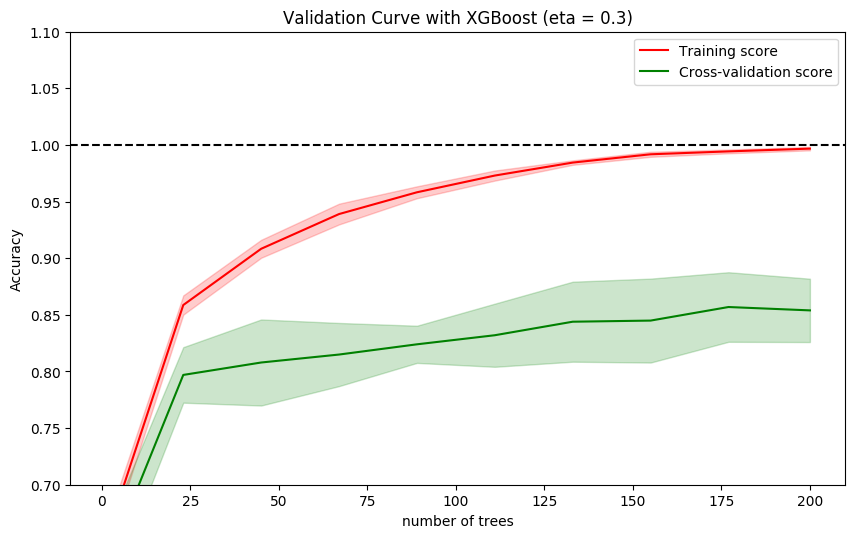

Best cross-validation result (0.86) obtained for 177 trees


In [28]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

fig = plt.figure(figsize=(10, 6), dpi=100)

plt.title("Validation Curve with XGBoost (eta = 0.3)")
plt.xlabel("number of trees")
plt.ylabel("Accuracy")
plt.ylim(0.7, 1.1)

plt.plot(n_estimators_range,
             train_scores_mean,
             label="Training score",
             color="r")

plt.plot(n_estimators_range,
             test_scores_mean, 
             label="Cross-validation score",
             color="g")

plt.fill_between(n_estimators_range, 
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, 
                 alpha=0.2, color="r")

plt.fill_between(n_estimators_range,
                 test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std,
                 alpha=0.2, color="g")

plt.axhline(y=1, color='k', ls='dashed')

plt.legend(loc="best")
plt.show()

i = np.argmax(test_scores_mean)
print("Best cross-validation result ({0:.2f}) obtained for {1} trees".format(test_scores_mean[i], n_estimators_range[i]))